(c) 2024 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [24]:
# Import project package
import Antibiotic

# Import project package
import AutoEncode
import AutoEncode.diffgeo.NeuralGeodesics as NG

# Import libraries to handel data
import CSV
import DataFrames as DF
import Glob

# Import ML libraries
import Flux

# Import library to save models
import JLD2

# Import basic math
import StatsBase
import Random
Random.seed!(42)

# Import Plotting libraries
using CairoMakie
import ColorSchemes

# Activate backend
CairoMakie.activate!()

# Set Plotting style
Antibiotic.viz.theme_makie!()

# Exploratory data analysis of the $\beta$-RHVAE results

`[explanation here]`

Let's begin by listing the files with the saved model.

In [2]:
# List files in output directory
files = Glob.glob("output/model_state/*.jld2")

first(files, 5)

5-element Vector{String}:
 "output/model_state/beta-rhvae_0.25temp_00001epoch.jld2"
 "output/model_state/beta-rhvae_0.25temp_00002epoch.jld2"
 "output/model_state/beta-rhvae_0.25temp_00003epoch.jld2"
 "output/model_state/beta-rhvae_0.25temp_00004epoch.jld2"
 "output/model_state/beta-rhvae_0.25temp_00005epoch.jld2"

Now, let's loop through each file, and load the values of the loss function and
the mean squared error for each model.

In [3]:
# Initialize empty dataframe
df_train = DF.DataFrame()
# Define fields to keep
fields = ["mse_train", "mse_val", "loss_train", "loss_val"]

# Loop through files
for f in files
    # spit file name to extract beta value and epoch number
    pars = split(f, "_")[end-1:end]
    # Parse beta value
    T = parse(Float64, replace(pars[1], "temp" => ""))
    # Parse epoch number
    epoch = parse(Int, replace(pars[2], ".jld2" => "", "epoch" => ""))
    # Load file and keep relevant fields
    file_load = JLD2.load(f)
    # Convert to dataframe
    df_tmp = DF.DataFrame(Dict(zip(fields, [file_load[x] for x in fields])))
    # Add beta and epoch to dataframe
    df_tmp[!, :temp] .= T
    df_tmp[!, :epoch] .= epoch

    # Append to main dataframe
    DF.append!(df_train, df_tmp)
end # for

# Sort by beta and epoch
DF.sort!(df_train, [:temp, :epoch])

first(df_train, 5)

5×6 DataFrame
 Row │ loss_train  loss_val  mse_train  mse_val   temp     epoch 
     │ Float32     Float32   Float32    Float32   Float64  Int64 
─────┼───────────────────────────────────────────────────────────
   1 │   109.788   112.38     0.925697  0.98944      0.25      1
   2 │   103.782   104.91     0.732909  0.766165     0.25      2
   3 │    99.4163  100.393    0.592547  0.607408     0.25      3
   4 │    95.393    96.2107   0.49419   0.520644     0.25      4
   5 │    93.4592   94.2148   0.433498  0.459071     0.25      5

With this information we can then plot the loss function and the mean squared
error for each model.

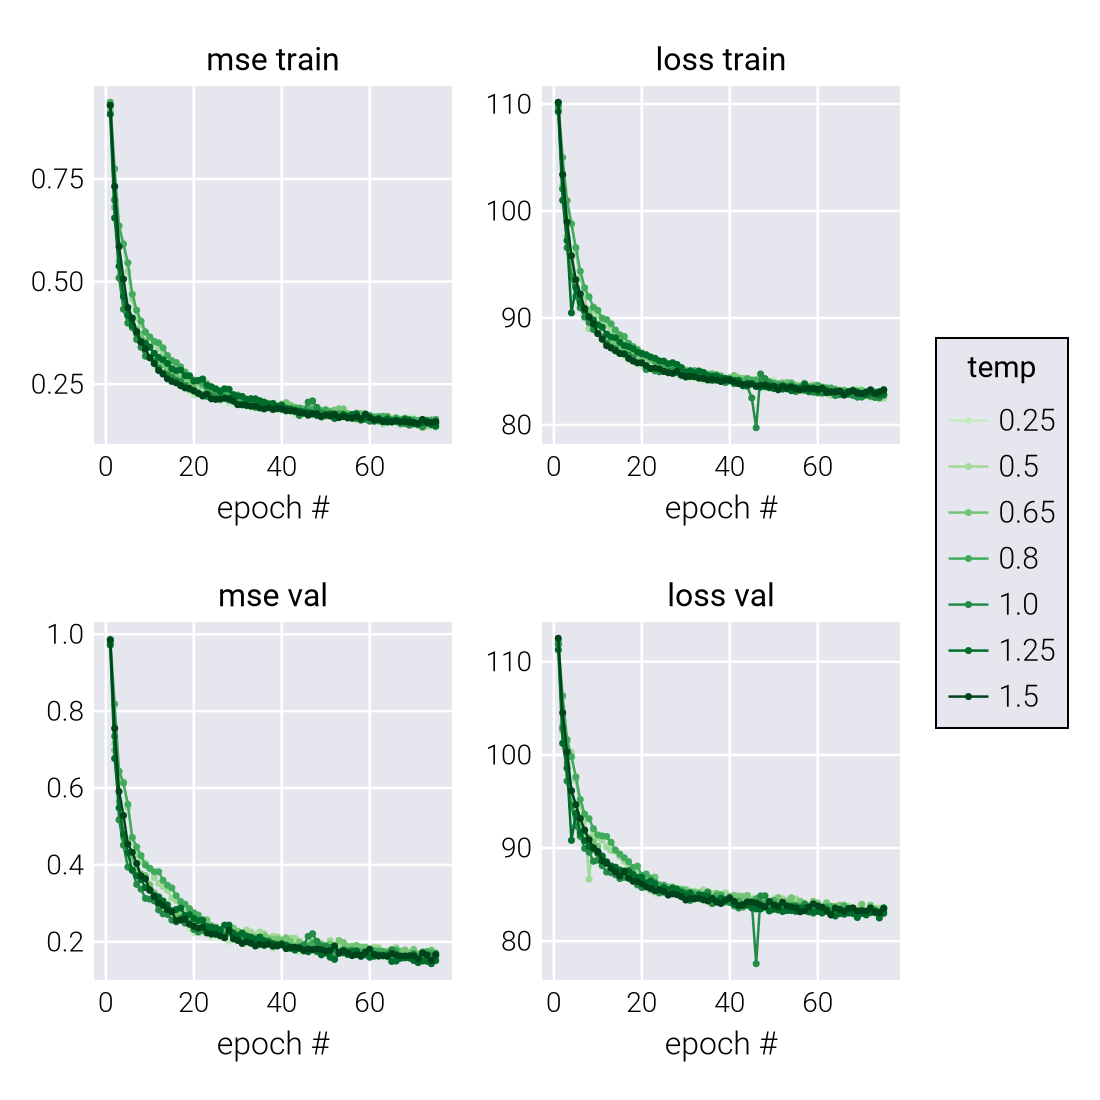

In [4]:
# Group data by β value
df_group = DF.groupby(df_train, :temp)

# Initialize figure
fig = Figure(size=(550, 550))

# Add axes to figure
axes = [
    Axis(
        fig[i, j],
        aspect=AxisAspect(1),
        xlabel="epoch #",
    ) for i in 1:2, j in 1:2
]

# Loop through fields
for (i, field) in enumerate(fields)
    # Get axis
    ax = axes[i]
    # Loop through groups
    for (j, df) in enumerate(df_group)
        # Get x and y values
        x = df.epoch
        y = df[:, field]
        # Plot
        scatterlines!(
            ax, x, y, color=ColorSchemes.Greens[j+2], markersize=5,
            label="$(df.temp[1])"
        )
    end # for
    # Set subplot title
    ax.title = replace(field, "_" => " ")
end # for

# Add legend to first subplot
Legend(fig[1:2, 3], axes[1], "temp", position=:rt)

fig

## Mapping points to latent space

All models get equivalent mean squared error reconstructions. So, let's explore
their latent space. First, let's load the models.

In [5]:
# Locate unique temperatures in file names
temps = sort(unique([split(f, "_")[end-1] for f in files]))

# Initialize empty dictionary to store models
rhvae_dict = Dict()

# Load model
rhvae_template = JLD2.load("./output/model.jld2")["model"]

# Loop through temperatures
for (i, temp) in enumerate(temps)
    # Add a dictionary entry for the temperature
    rhvae_dict["$(temp)"] = Dict()
    # Parse temperature value
    T = parse(Float32, replace(temp, "temp" => ""))
    # Load model
    rhvae_dict["$(temp)"]["model"] = AutoEncode.RHVAEs.RHVAE(
        deepcopy(rhvae_template.vae),
        deepcopy(rhvae_template.metric_chain),
        deepcopy(rhvae_template.centroids_data),
        deepcopy(rhvae_template.centroids_latent),
        deepcopy(rhvae_template.L),
        deepcopy(rhvae_template.M),
        T,
        deepcopy(rhvae_template.λ)
    )
    # Search for model files
    model_files = Glob.glob("./output/model_state/*$(temp)*.jld2")
    println("$(model_files[end])")
    # Load parameters
    model_state = JLD2.load(model_files[end])["model_state"]
    # Set model parameters
    Flux.loadmodel!(rhvae_dict["$(temp)"]["model"], model_state)
    # Update metric
    AutoEncode.RHVAEs.update_metric!(rhvae_dict["$(temp)"]["model"])
end # for

./output/model_state/beta-rhvae_0.25temp_00075epoch.jld2
./output/model_state/beta-rhvae_0.5temp_00075epoch.jld2
./output/model_state/beta-rhvae_0.65temp_00075epoch.jld2
./output/model_state/beta-rhvae_0.8temp_00075epoch.jld2
./output/model_state/beta-rhvae_1.0temp_00075epoch.jld2
./output/model_state/beta-rhvae_1.25temp_00075epoch.jld2
./output/model_state/beta-rhvae_1.5temp_00075epoch.jld2


Now, we can load the data.

In [6]:
# Define data directory
data_dir = "$(git_root())/data/Iwasawa_2022"

# Load file into memory
df_ic50 = CSV.read("$(data_dir)/iwasawa_ic50_tidy.csv", DF.DataFrame)

# Locate strains with missing values
missing_strains = unique(df_ic50[ismissing.(df_ic50.log2ic50), :strain])

# Remove data
df_ic50 = df_ic50[[x ∉ missing_strains for x in df_ic50.strain], :]

# Group data by strain and day
df_group = DF.groupby(df_ic50, [:strain, :day])

# Extract unique drugs to make sure the matrix is built correctly
drug = sort(unique(df_ic50.drug))

# Initialize matrix to save ic50 values
ic50_mat = Matrix{Float32}(undef, length(drug), length(df_group))

# Loop through groups
for (i, data) in enumerate(df_group)
    # Sort data by stress
    DF.sort!(data, :drug)
    # Check that the stress are in the correct order
    if all(data.drug .== drug)
        # Add data to matrix
        ic50_mat[:, i] = Float32.(data.log2ic50)
    else
        println("group $i stress does not match")
    end # if
end # for

# Define number of environments
n_env = size(ic50_mat, 1)
# Define number of samples
n_samples = size(ic50_mat, 2)

# Fit model to standardize data to mean zero and standard deviation 1 on each
# environment
dt = StatsBase.fit(StatsBase.ZScoreTransform, ic50_mat, dims=2)

# Center data to have mean zero and standard deviation one
ic50_std = StatsBase.transform(dt, ic50_mat)

8×1269 Matrix{Float32}:
 -0.549695  -0.636041  -0.645549  …  -0.52737   -0.567254  -0.489156
  0.127085   0.396026   0.422921      0.152449   0.106901   0.0836802
 -0.952641  -0.814063  -0.947413     -0.712676  -0.723125  -0.706011
  0.434811  -0.480968  -0.244397      0.702219   0.484944   0.544966
 -0.469319  -0.463574  -0.461562     -0.450975  -0.278867  -0.296857
  0.689883   0.638487   0.126388  …   0.910045   0.774161   0.968758
  0.22606    0.13382    0.396659     -0.436597  -0.589569  -0.649776
 -0.605906  -0.748028  -0.533354     -0.860089  -1.17661   -0.934113

Let's now encode the data using the model encoder to obtain the latent space
representation of the data.

In [7]:
# Loop through temperatures
for temp in temps
    # Encode data to latent space
    latent = rhvae_dict["$(temp)"]["model"].vae.encoder(ic50_std).µ
    # Add latent space to dictionary
    rhvae_dict["$(temp)"]["latent"] = latent
end # for

Let's plot the latent space representation of the data.

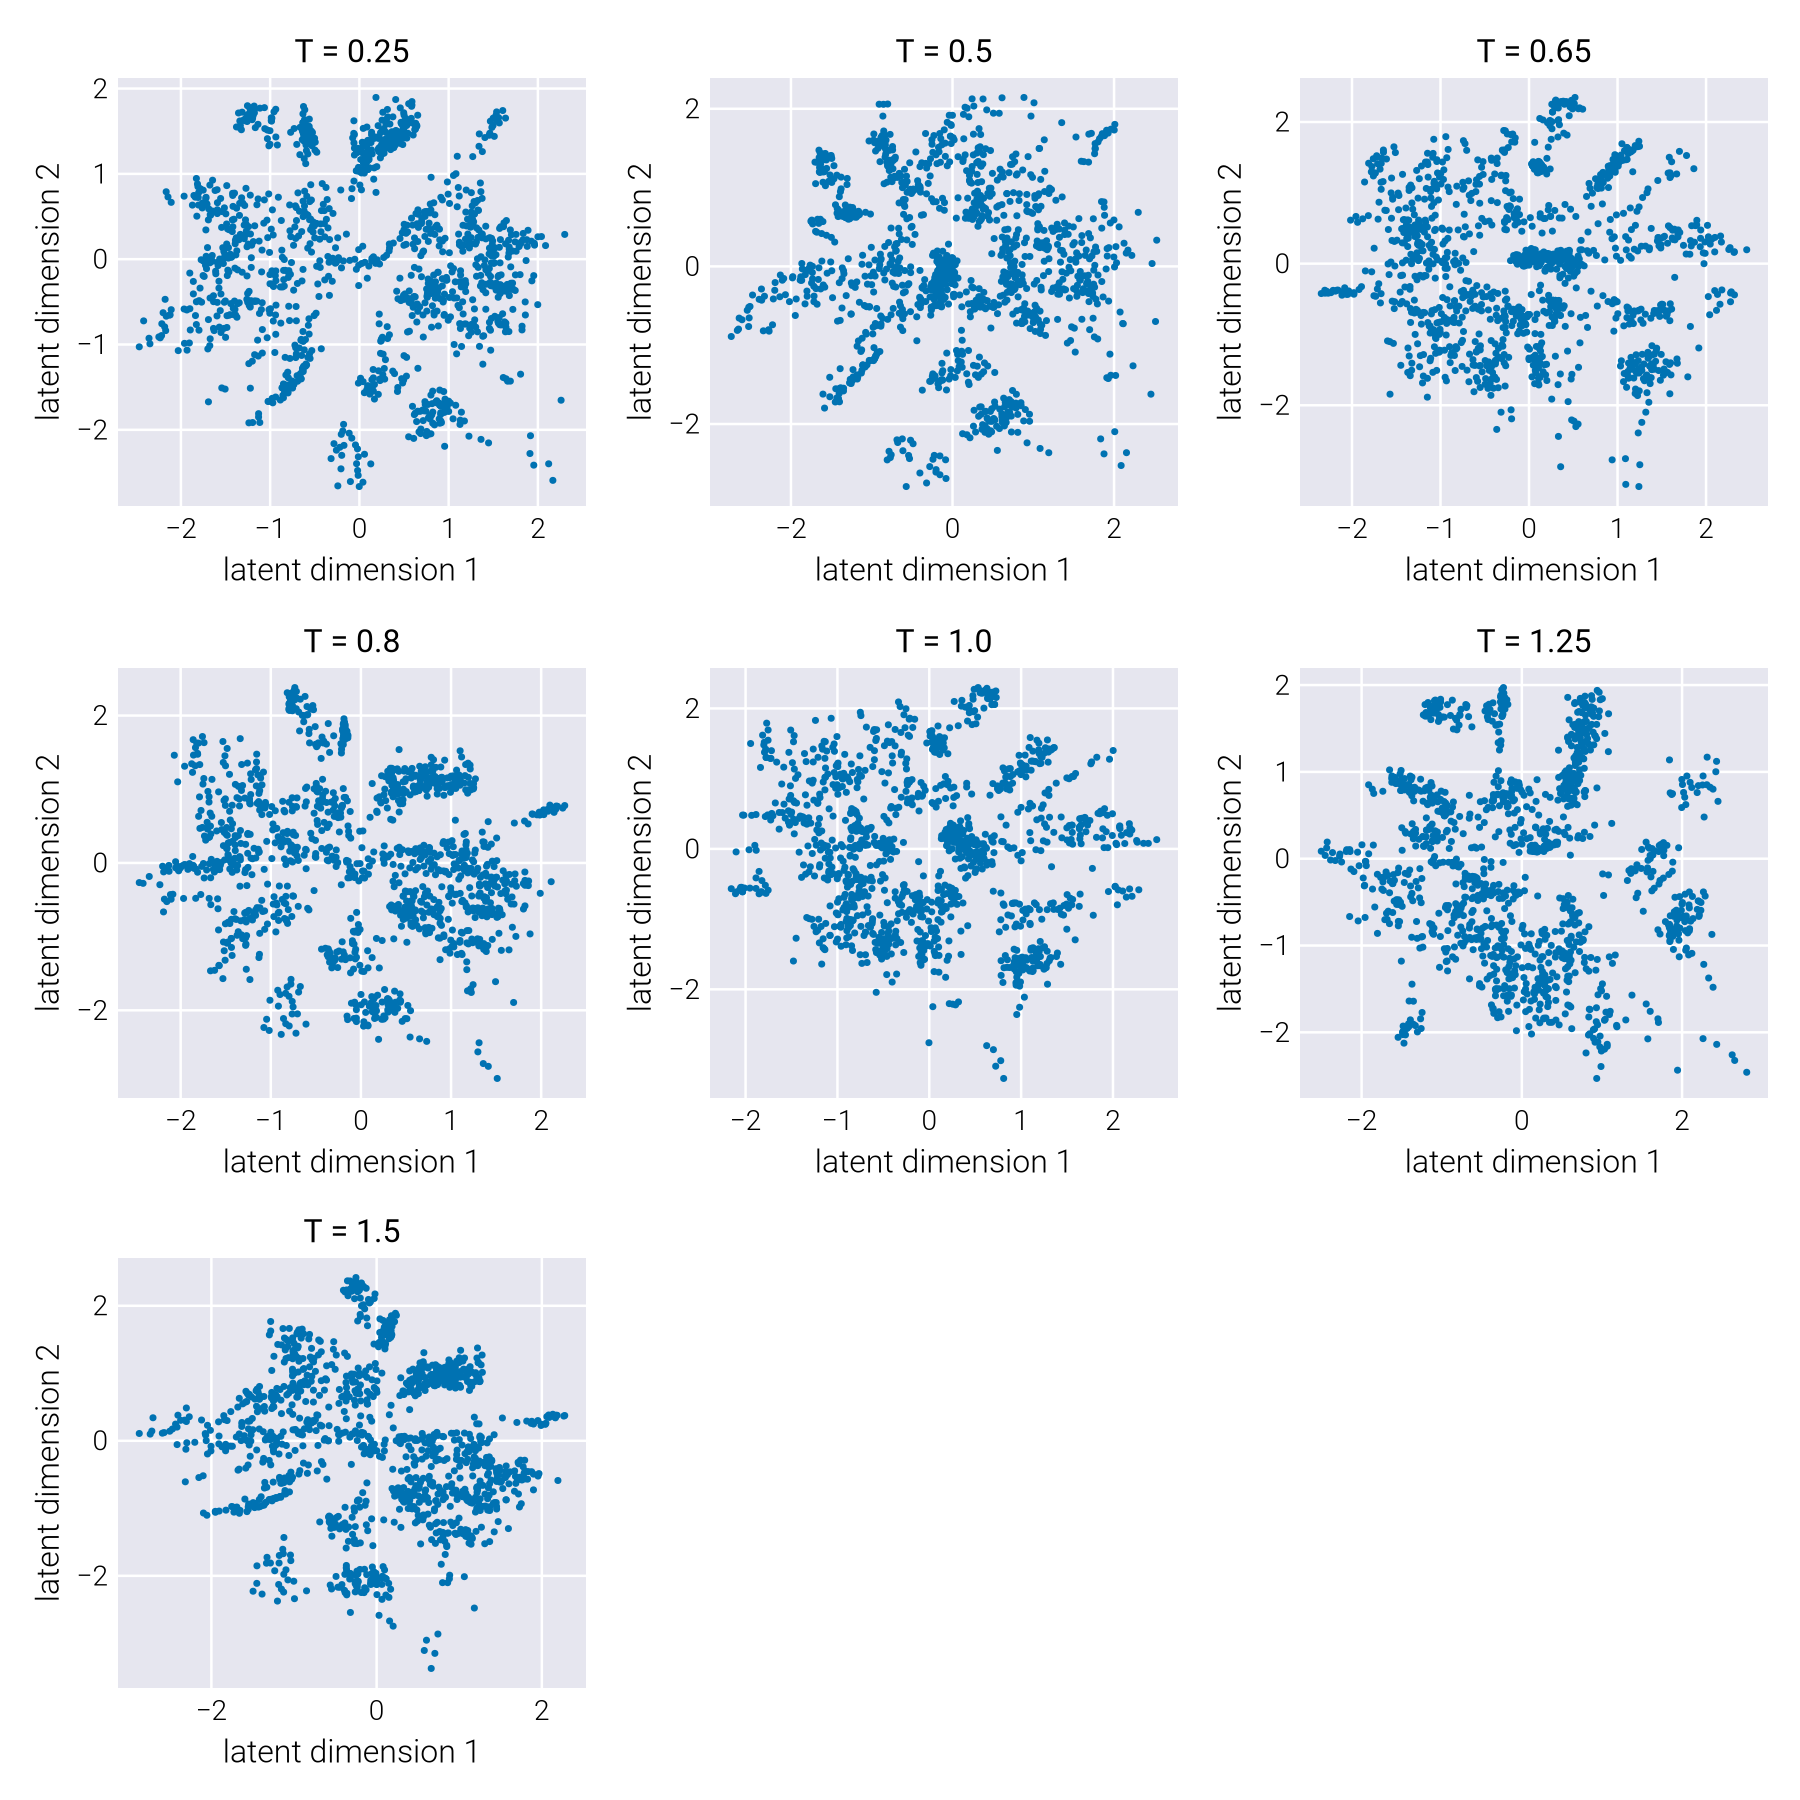

In [8]:
# Initialize plot
fig = Figure(size=(900, 900))

# Define the number of rows and columns
rows = 3
cols = 3

# Loop through temperatures
for (i, temp) in enumerate(temps)
    # Get latent space
    latent = rhvae_dict["$(temp)"]["latent"]

    # Calculate row and column indices
    row = (i - 1) ÷ cols + 1
    col = (i - 1) % cols + 1

    # Add axis to plot
    ax = Axis(
        fig[row, col],
        xlabel="latent dimension 1",
        ylabel="latent dimension 2",
    )
    # Add scatter plot to axis
    scatter!(
        ax,
        latent[1, :],
        latent[2, :],
        markersize=5,
    )
    # Set subplot title
    ax.title = "T = $(replace(temp, "temp" => ""))"
end # for

fig

There is some interesting structure. But, we need to compute the metric to know the curvature of the latent space. Let's do that next.

In [9]:
# Define number of points per axis
n_points = 250

# Define range of latent space
latent_range = Float32.(range(-5, 5, length=n_points))

# Define latent points to evaluate
z_mat = reduce(hcat, [[x, y] for x in latent_range, y in latent_range])

# Loop through temperatures
for temp in temps

    # Compute inverse metric tensor
    Ginv = AutoEncode.RHVAEs.G_inv(z_mat, rhvae_dict["$(temp)"]["model"])

    # Compute log determinant of metric tensor
    rhvae_dict["$(temp)"]["logdetG"] = reshape(
        -1 / 2 * AutoEncode.utils.slogdet(Ginv), n_points, n_points
    )
end # for

┌ Info: The CUDA function is being called but CUDA.jl is not functional.
│ Defaulting back to the CPU. (No action is required if you want to run on the CPU).
└ @ FluxCUDAExt /Users/mrazo/.julia/packages/Flux/qZO6T/ext/FluxCUDAExt/FluxCUDAExt.jl:35


Now, let's plot the metric as the background color of the latent space.

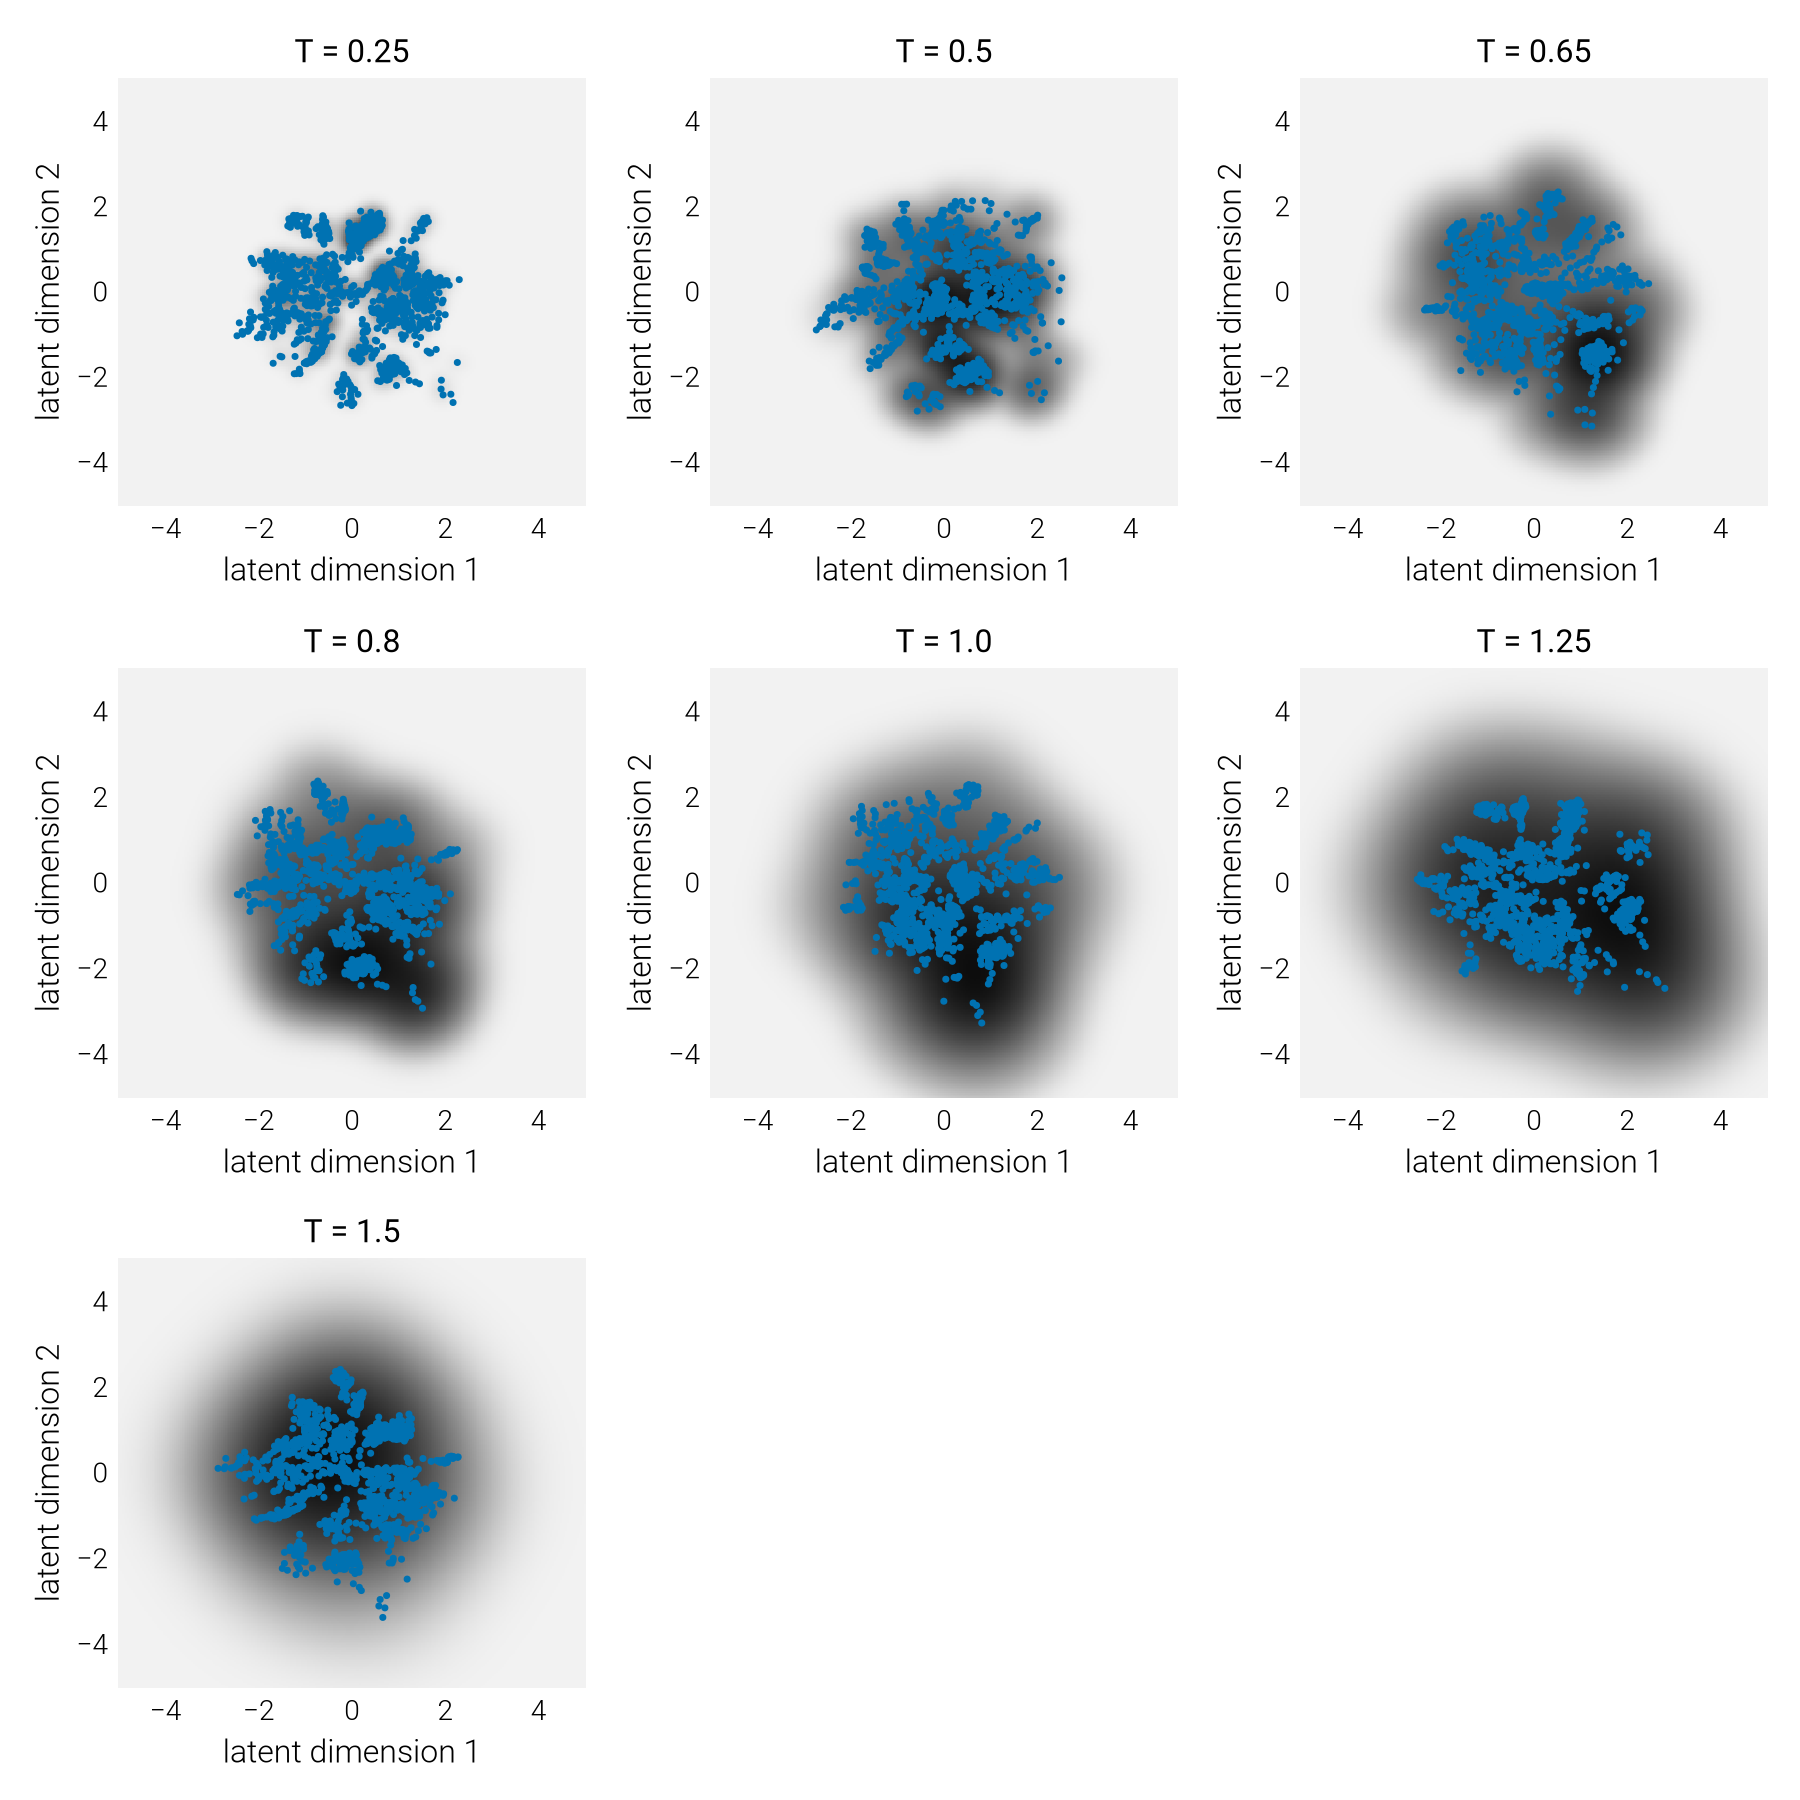

In [10]:
# Initialize plot
fig = Figure(size=(900, 900))

# Define the number of rows and columns
rows = 3
cols = 3

# Loop through temperatures
for (i, temp) in enumerate(temps)
    # Get latent space
    latent = rhvae_dict["$(temp)"]["latent"]

    # Get log determinant of metric tensor
    logdetG = rhvae_dict["$(temp)"]["logdetG"]

    # Calculate row and column indices
    row = (i - 1) ÷ cols + 1
    col = (i - 1) % cols + 1

    # Add axis to plot
    ax = Axis(
        fig[row, col],
        xlabel="latent dimension 1",
        ylabel="latent dimension 2",
    )
    # Plot heatmap of log determinant of metric tensor
    hm = heatmap!(ax, latent_range, latent_range, logdetG, colormap=:grays)
    # Add scatter plot to axis
    scatter!(
        ax,
        latent[1, :],
        latent[2, :],
        markersize=5,
    )
    # Set subplot title
    ax.title = "T = $(replace(temp, "temp" => ""))"
end # for

fig

Let's extract these latent space representations and append the corresponding
metadata.

In [11]:
# Extract strains as ordered in ic50 matrix
strains_mat = [x.strain for x in keys(df_group)]
day_mat = [x.day for x in keys(df_group)]

# Initialize empty dataframe
df_meta_mat = DF.DataFrame()

# Loop through temperatures
for temp in temps
    # Extract latent space
    latent = rhvae_dict["$(temp)"]["latent"]
    # Generate dataframe with corresponding metadata
    DF.append!(
        df_meta_mat,
        DF.DataFrame(
            strain=strains_mat,
            day=day_mat,
            z1=latent[1, :],
            z2=latent[2, :],
            temp=temp
        )
    )
end # for

# Add corresponding metadata resistance value
df_meta_mat = DF.leftjoin!(
    df_meta_mat,
    unique(df_ic50[:, [:strain, :day, :parent, :env]]),
    on=[:strain, :day]
)

first(df_meta_mat, 5)

5×7 DataFrame
 Row │ strain           day    z1          z2         temp       parent   env  ⋯
     │ String31         Int64  Float32     Float32    SubStrin…  String7  Stri ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Parent in TET 1      1   0.227557    1.25856   0.25temp   Parent   TET  ⋯
   2 │ Parent in TET 1      2   0.088802    1.15696   0.25temp   Parent   TET
   3 │ Parent in TET 1      3   0.0418531   1.05375   0.25temp   Parent   TET
   4 │ Parent in TET 1      4  -0.335964   -0.42417   0.25temp   Parent   TET
   5 │ Parent in TET 1      5  -0.352176    0.366628  0.25temp   Parent   TET  ⋯
                                                                1 column omitted

We can now repeat the same plot as above, but this time coloring each point by
their strain.

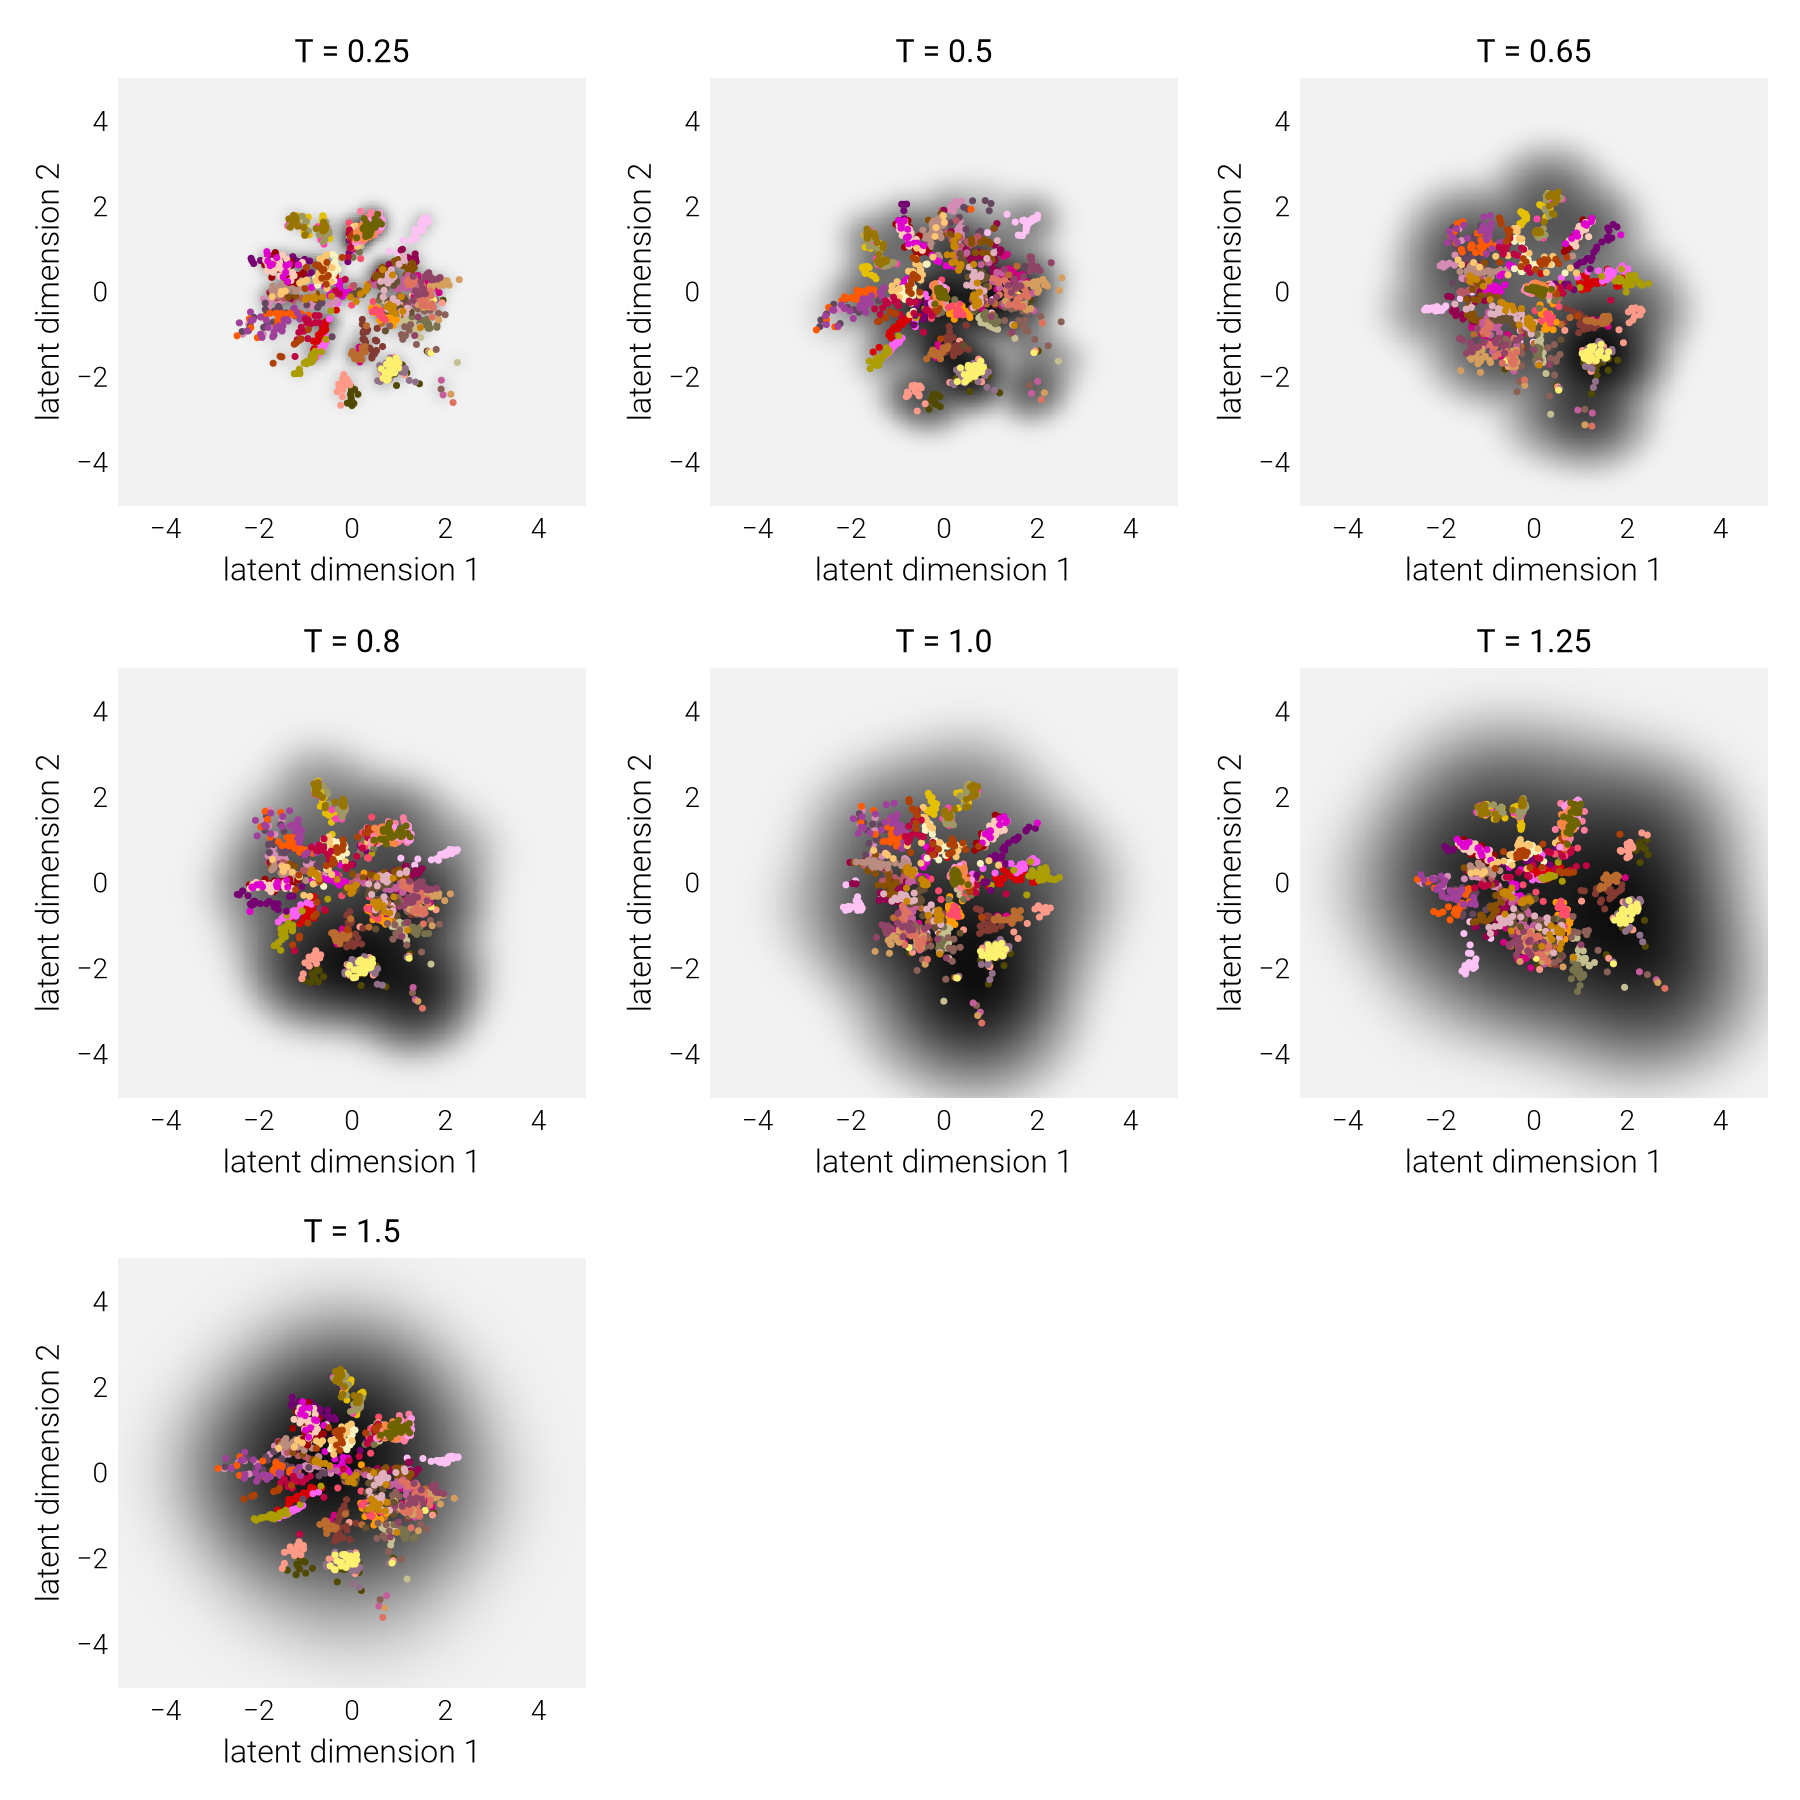

In [12]:
# Initialize plot
fig = Figure(size=(900, 900))

# Define the number of rows and columns
rows = 3
cols = 3

# Loop through temperatures
for (i, temp) in enumerate(temps)
    # Get latent space
    latent = rhvae_dict["$(temp)"]["latent"]

    # Get log determinant of metric tensor
    logdetG = rhvae_dict["$(temp)"]["logdetG"]

    # Calculate row and column indices
    row = (i - 1) ÷ cols + 1
    col = (i - 1) % cols + 1

    # Add axis to plot
    ax = Axis(
        fig[row, col],
        xlabel="latent dimension 1",
        ylabel="latent dimension 2",
    )
    # Plot heatmap of log determinant of metric tensor
    hm = heatmap!(ax, latent_range, latent_range, logdetG, colormap=:grays)
    # Group data by resistance
    df_group = DF.groupby(df_meta_mat[(df_meta_mat.temp.==temp), :], :strain)

    # Loop through groups
    for (j, data) in enumerate(df_group)
        # Add scatter plot to axis
        scatter!(
            ax,
            data.z1,
            data.z2,
            markersize=5,
            label=data.strain[1],
            color=ColorSchemes.glasbey_bw_minc_20_hue_330_100_n256[j],
        )
    end

    # Set subplot title
    ax.title = "T = $(replace(temp, "temp" => ""))"
end # for

fig

Let's repeat this process but this time coloring the points by the environment
(antibiotic) in which they evolved.

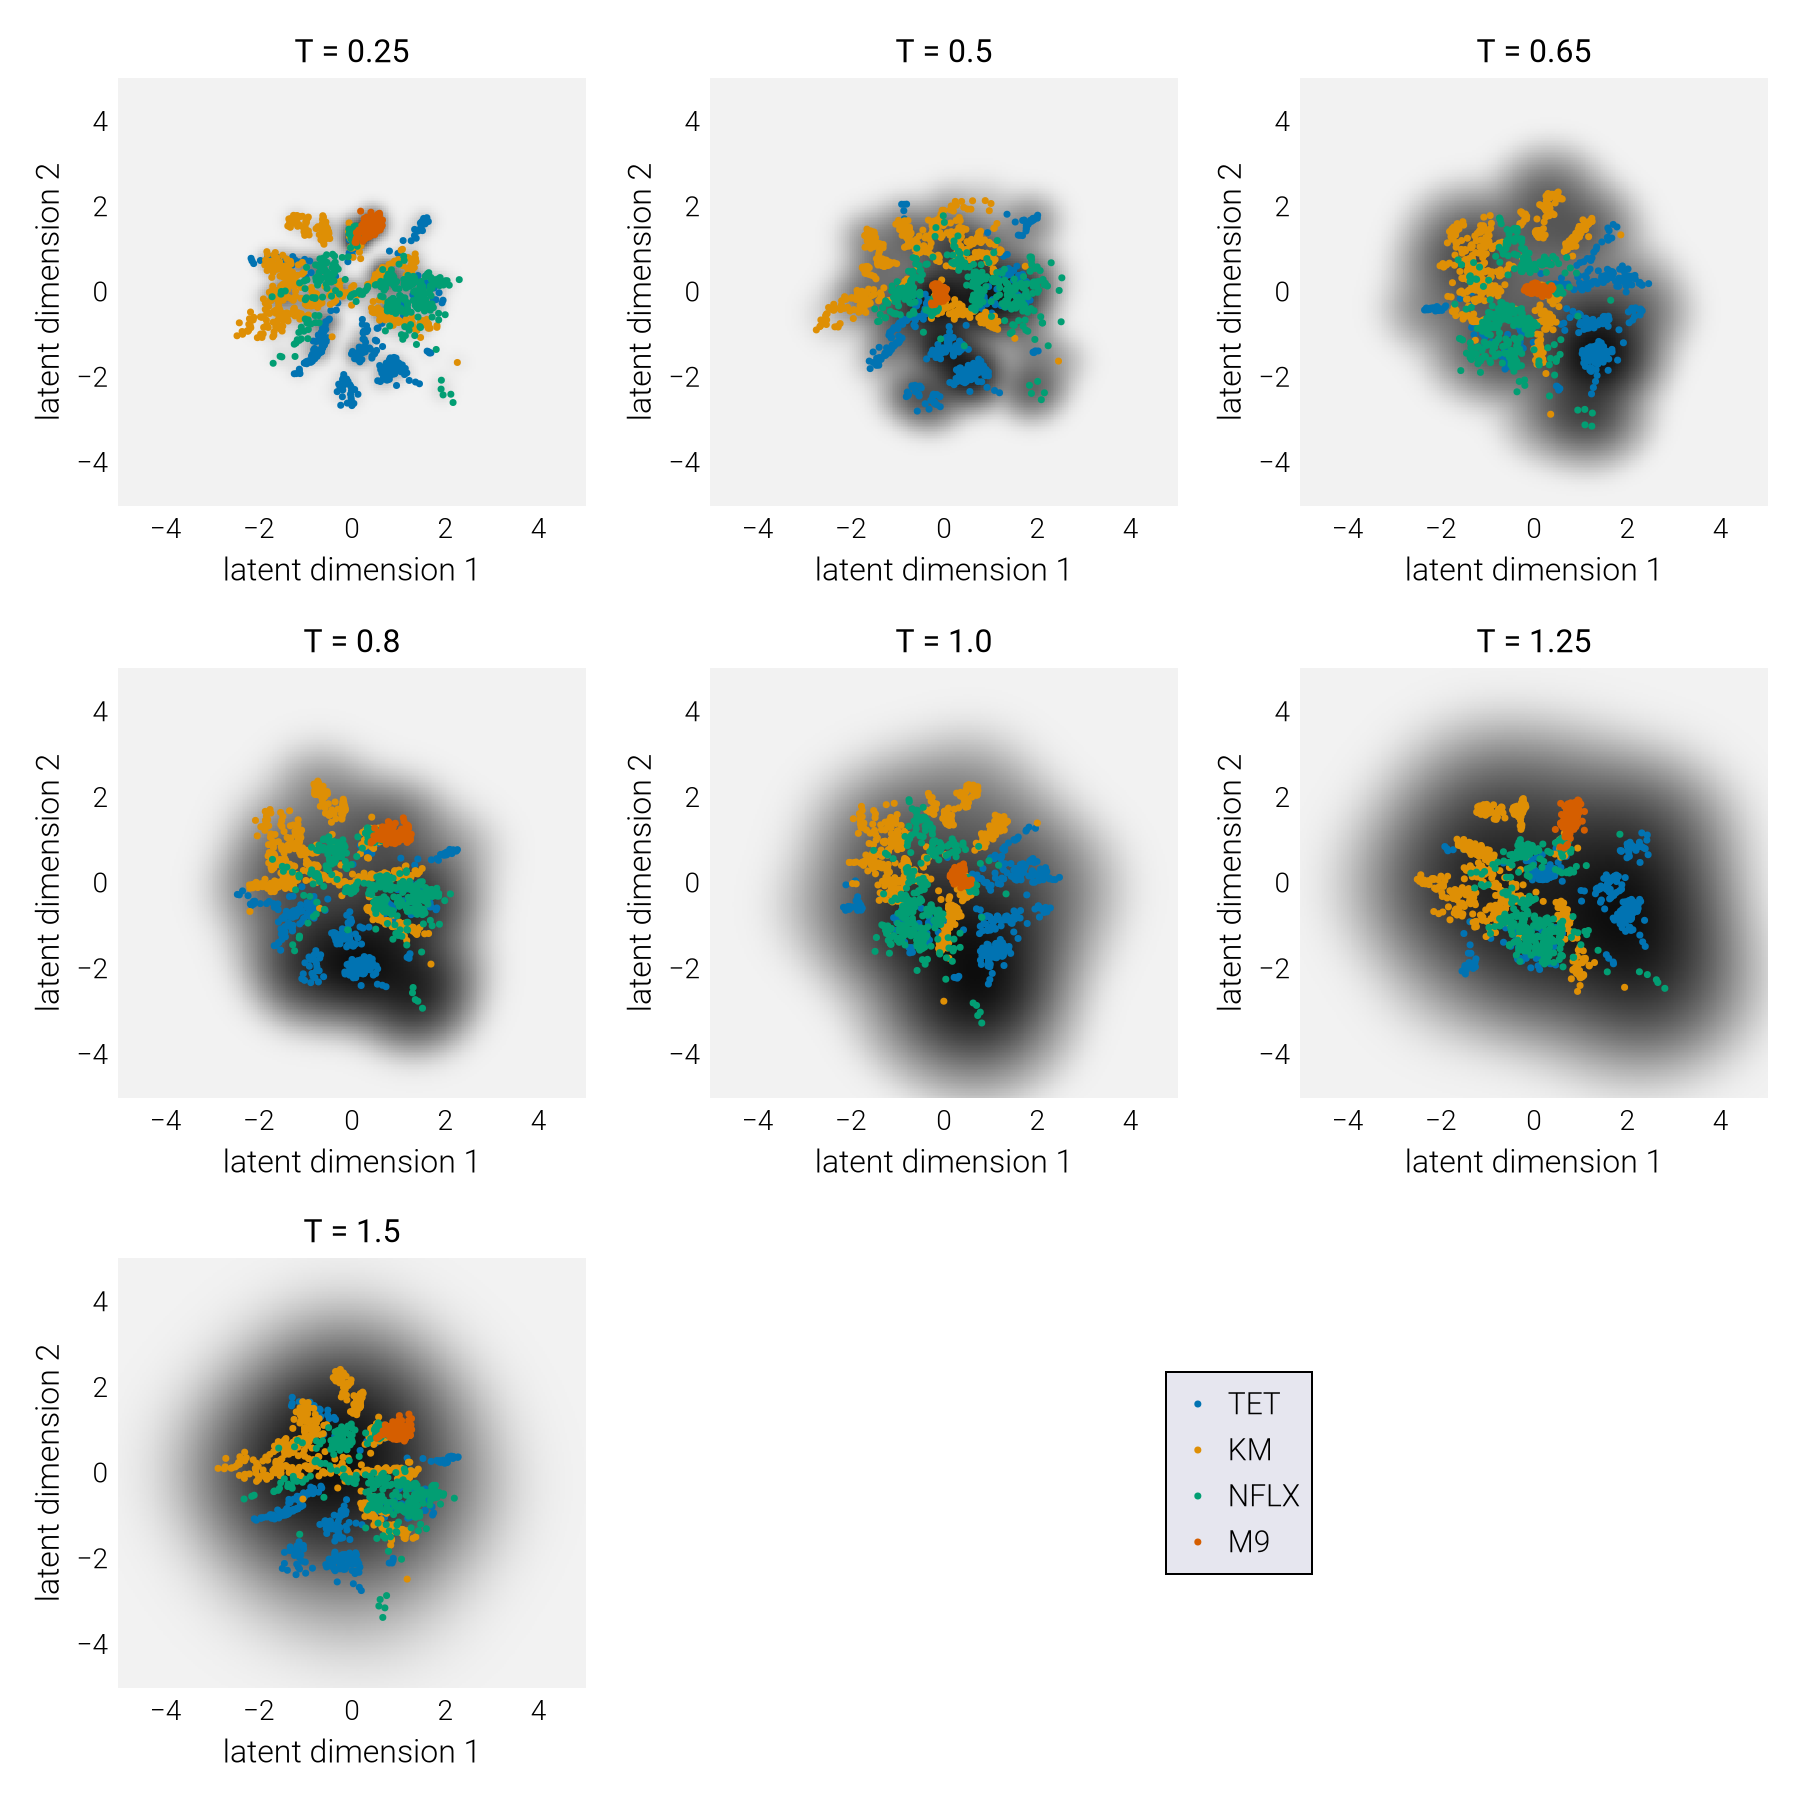

In [13]:
# Initialize plot
fig = Figure(size=(900, 900))

# Define the number of rows and columns
rows = 3
cols = 3

# Loop through temperatures
for (i, temp) in enumerate(temps)
    # Get latent space
    latent = rhvae_dict["$(temp)"]["latent"]

    # Get log determinant of metric tensor
    logdetG = rhvae_dict["$(temp)"]["logdetG"]

    # Calculate row and column indices
    row = (i - 1) ÷ cols + 1
    col = (i - 1) % cols + 1

    # Add axis to plot
    ax = Axis(
        fig[row, col],
        xlabel="latent dimension 1",
        ylabel="latent dimension 2",
    )
    # Plot heatmap of log determinant of metric tensor
    hm = heatmap!(ax, latent_range, latent_range, logdetG, colormap=:grays)
    # Group data by resistance
    df_group = DF.groupby(df_meta_mat[(df_meta_mat.temp.==temp), :], :env)

    # Loop through groups
    for (j, data) in enumerate(df_group)
        # Add scatter plot to axis
        scatter!(
            ax,
            data.z1,
            data.z2,
            markersize=5,
            label=data.env[1],
            color=ColorSchemes.seaborn_colorblind[j],
            aspect=AxisAspect(1),
        )
    end

    # Set subplot title
    ax.title = "T = $(replace(temp, "temp" => ""))"

    # Check if last subplot
    if temp == temps[end]
        # Add legend to last subplot
        fig[3, 2:3] = Legend(fig, ax)
    end # if
end # for

fig

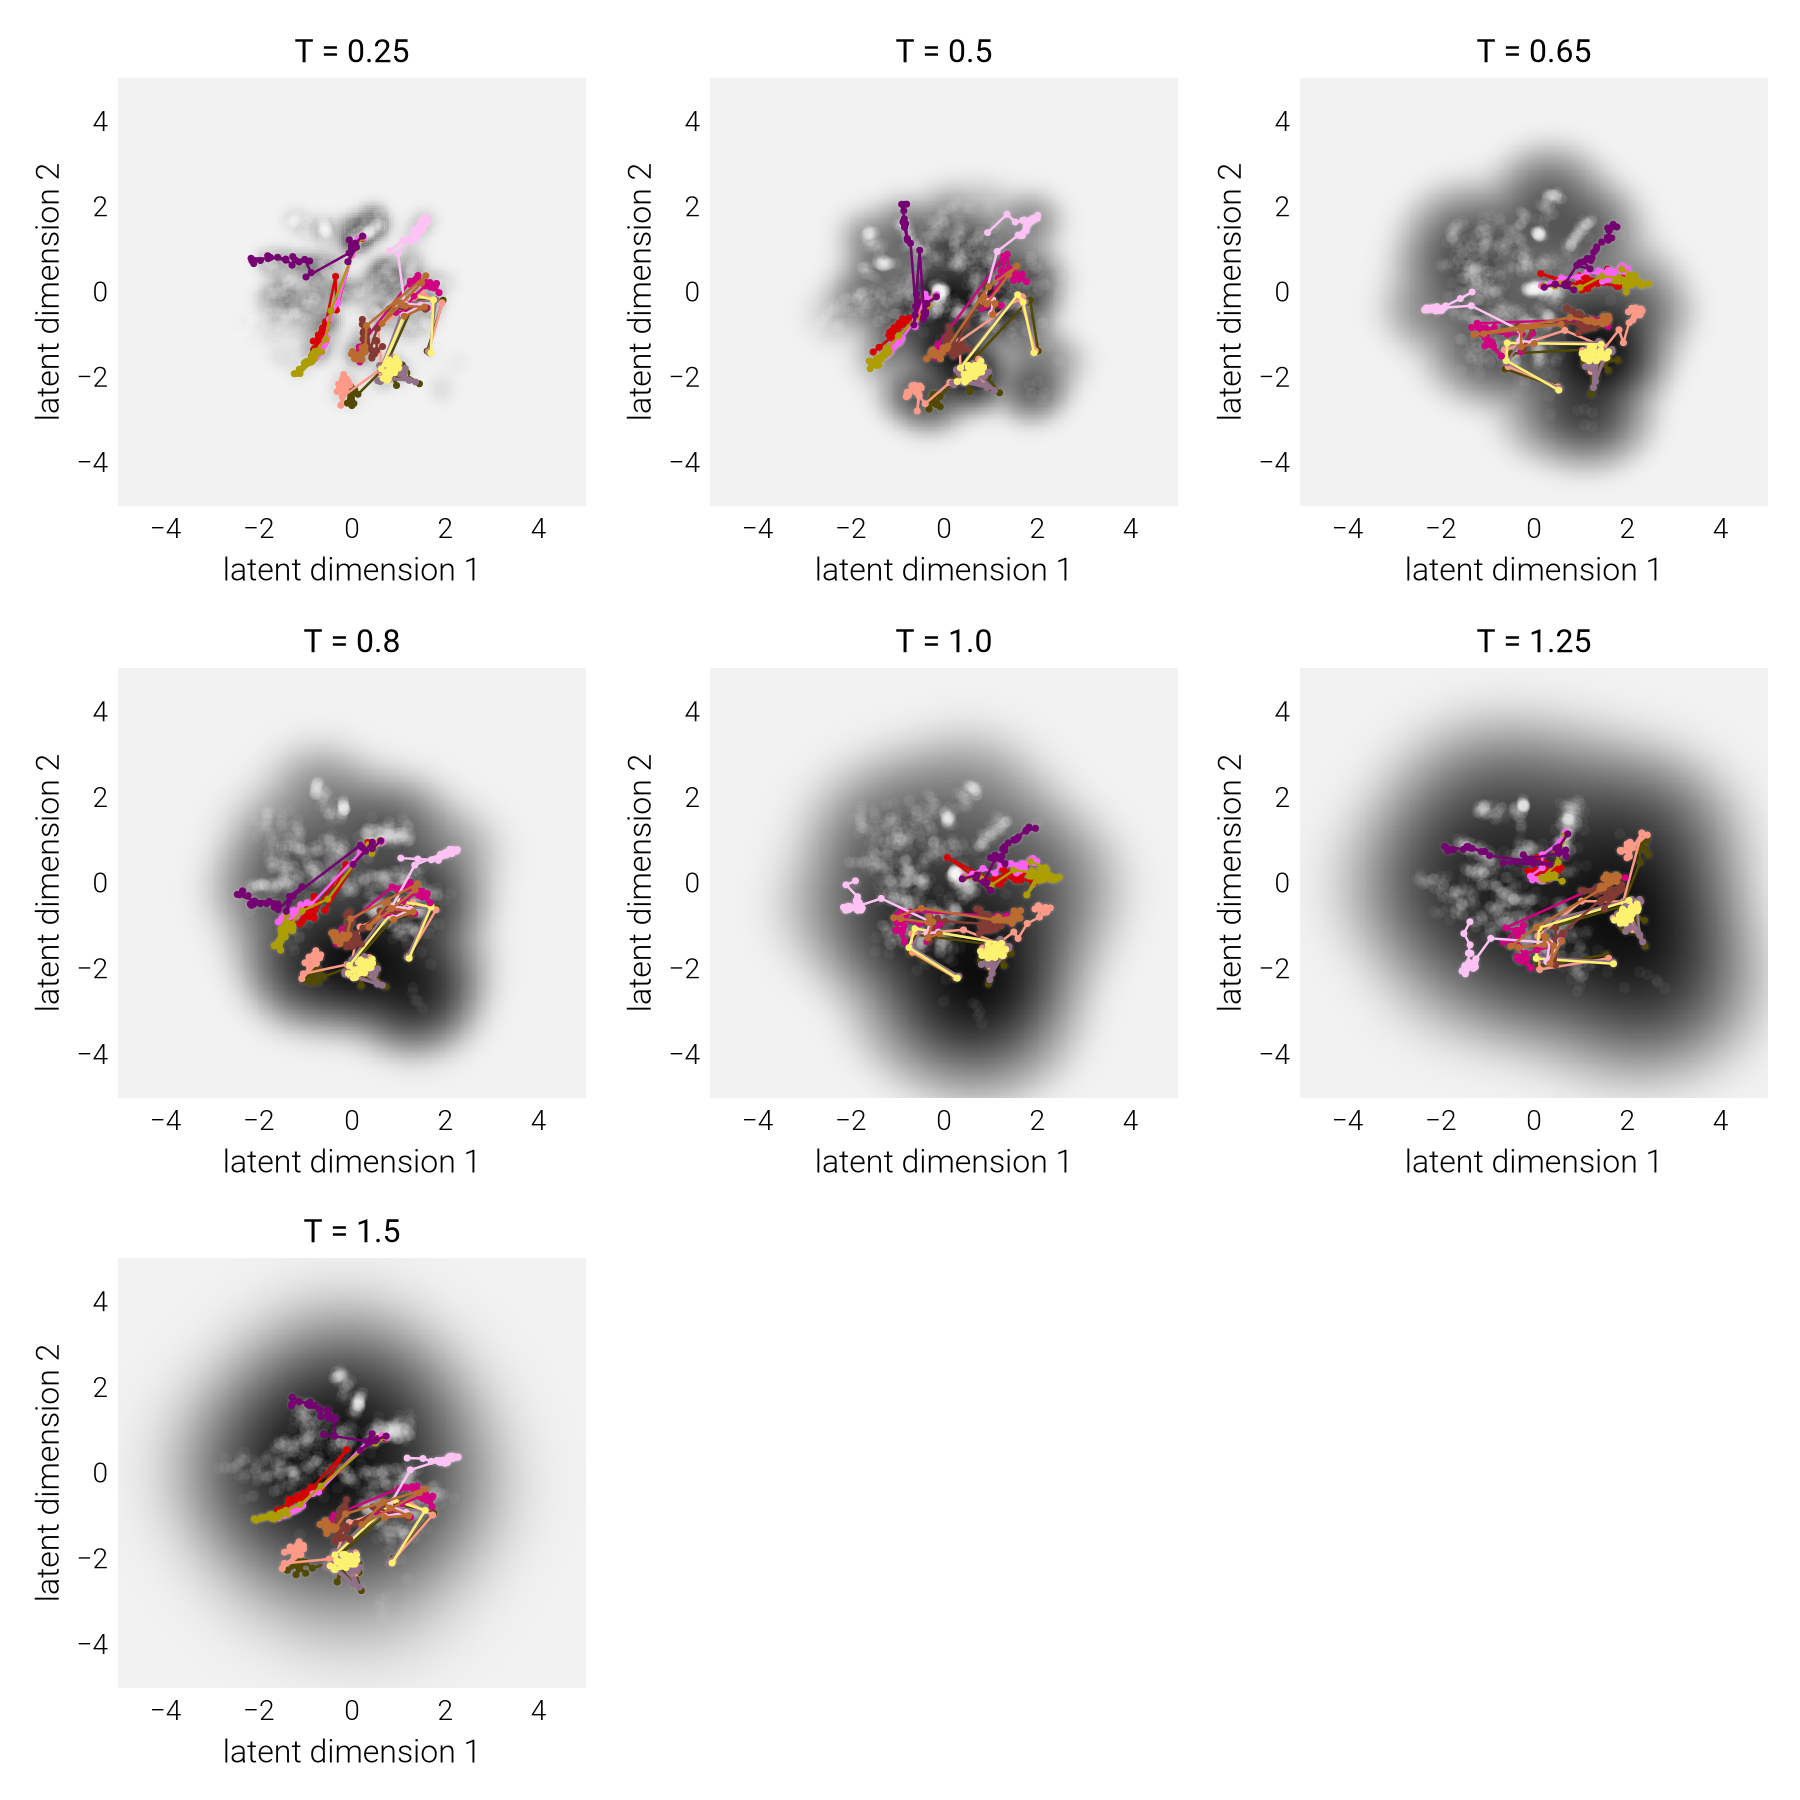

In [17]:
# Initialize plot
fig = Figure(size=(900, 900))

# Define the number of rows and columns
rows = 3
cols = 3

# Loop through temperatures
for (i, temp) in enumerate(temps)
    # Get latent space
    latent = rhvae_dict["$(temp)"]["latent"]

    # Get log determinant of metric tensor
    logdetG = rhvae_dict["$(temp)"]["logdetG"]

    # Calculate row and column indices
    row = (i - 1) ÷ cols + 1
    col = (i - 1) % cols + 1

    # Add axis to plot
    ax = Axis(
        fig[row, col],
        xlabel="latent dimension 1",
        ylabel="latent dimension 2",
    )
    # Plot heatmap of log determinant of metric tensor
    hm = heatmap!(ax, latent_range, latent_range, logdetG, colormap=:grays)
    # Extract data
    data = df_meta_mat[(df_meta_mat.temp.==temp), :]

    # Add scatter plot to axis
    scatter!(
        ax,
        data.z1,
        data.z2,
        markersize=8,
        color=(:white, 0.05),
    )

    # Group data by strain
    df_group = DF.groupby(data[data.env.=="TET", :], :strain)

    # Loop through groups
    for (j, data) in enumerate(df_group)
        # Add scatter plot to axis
        scatterlines!(
            ax,
            data.z1,
            data.z2,
            markersize=5,
            label=data.strain[1],
            color=ColorSchemes.glasbey_bw_minc_20_hue_330_100_n256[j],
        )
    end

    # Set subplot title
    ax.title = "T = $(replace(temp, "temp" => ""))"
end # for

fig

## Geodesic computation

In [22]:
# Define temperature
temp = "0.65temp"
# Extract model for test
rhvae = rhvae_dict[temp]["model"]
# Extract data
data = df_meta_mat[(df_meta_mat.temp.==temp), :]

# Group data by strain and select example strain
df_strain = DF.sort(
    DF.groupby(data[data.env.=="TET", :], :strain)[4], :day
)

# Extract initial and final points for strain
z_init = [df_strain.z1[1], df_strain.z2[1]]
z_end = [df_strain.z1[end], df_strain.z2[end]]


2-element Vector{Float32}:
 1.5846804
 1.501445

In [29]:
# Extract dimensionality of latent space
ldim = size(rhvae.centroids_latent, 1)
# Define number of neurons in hidden layers
n_neuron = 32

# Define mlp chain
mlp_chain = Flux.Chain(
    # First layer
    Flux.Dense(1 => n_neuron, Flux.identity),
    # Second layer
    Flux.Dense(n_neuron => n_neuron, Flux.relu),
    # Third layer
    Flux.Dense(n_neuron => n_neuron, Flux.relu),
    # Fourth layer
    Flux.Dense(n_neuron => n_neuron, Flux.relu),
    # Output layer
    Flux.Dense(n_neuron => ldim, Flux.identity)
)

# Define NeuralGeodesic
nng = NG.NeuralGeodesic(mlp_chain, z_init, z_end)

AutoEncode.diffgeo.NeuralGeodesics.NeuralGeodesic(Chain(Dense(1 => 32), Dense(32 => 32, relu), Dense(32 => 32, relu), Dense(32 => 32, relu), Dense(32 => 2)), Float32[0.22075617, 0.11126725], Float32[1.5846804, 1.501445])

In [42]:
# Define learning rate
η = 1e-3
# Define number of time points to sample
n_time = 100
# Define number of epochs
n_epoch = 250

# Define time points
t_array = Float32.(collect(range(0, 1, length=n_time)))

# Explicit setup of optimizer
opt_nng = Flux.Train.setup(
    Flux.Optimisers.Adam(η),
    nng
)

# Define loss function keyword arguments
loss_kwargs = Dict(
    :curve_velocity => NG.curve_velocity_finitediff,
    :vec_mat_vec => NG.vec_mat_vec_batched,
    :curve_integral => NG.curve_energy,
)

# Initialize empty array to save loss
nng_loss = Vector{Float32}(undef, n_epoch)

# Loop through epochs
for epoch in 1:n_epoch
    # Train model and save loss
    nng_loss[epoch] = NG.train!(
        nng, rhvae, t_array, opt_nng; loss_kwargs=loss_kwargs, loss_return=true
    )
end # for

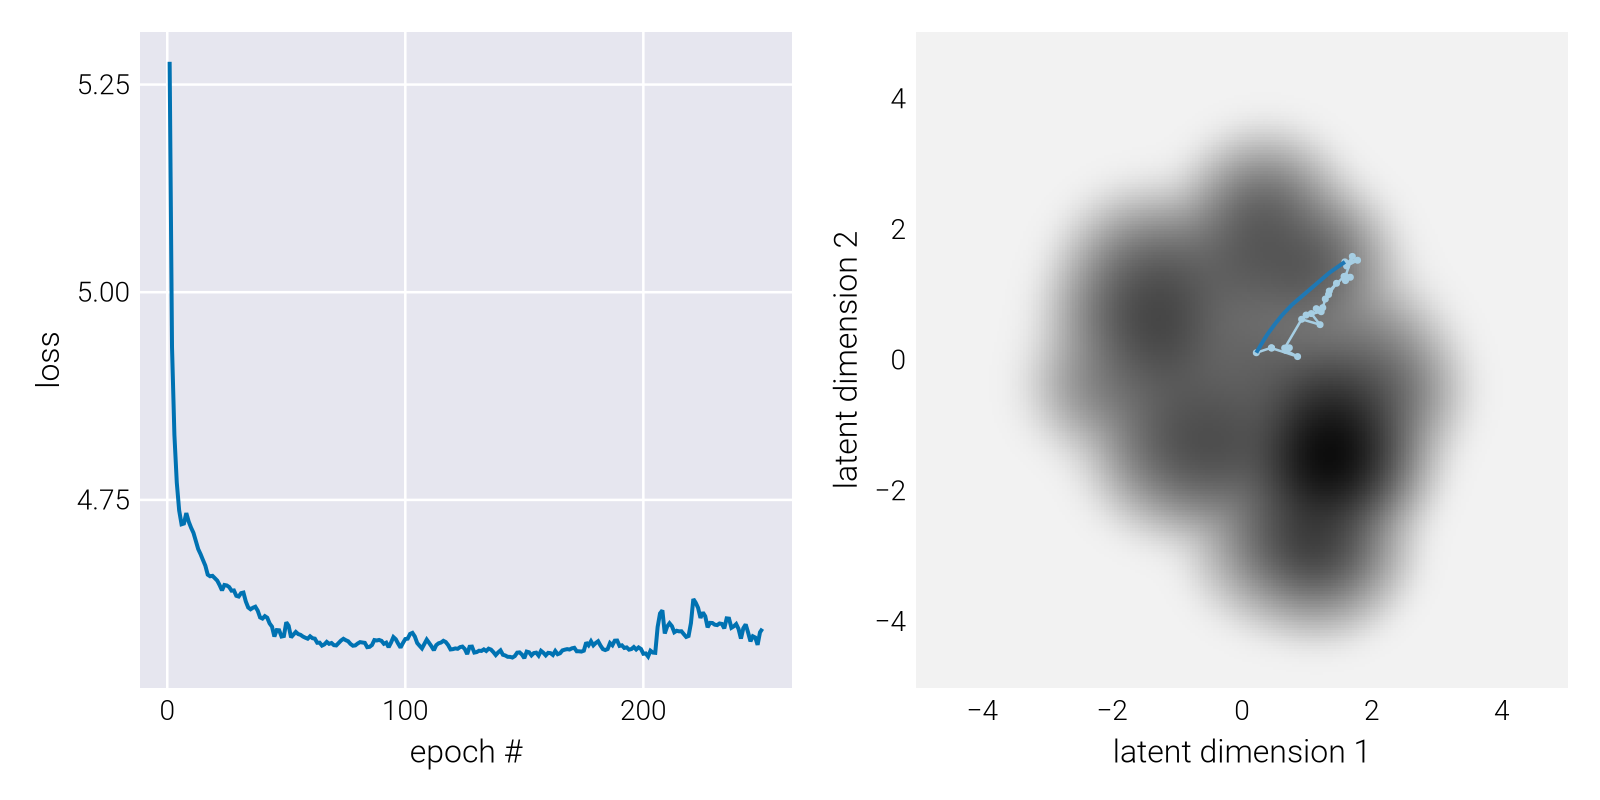

In [43]:
# Initialize figure
fig = Figure(size=(800, 400))

# Add axis to figure
ax1 = Axis(fig[1, 1], xlabel="epoch #", ylabel="loss")

# Plot loss
lines!(ax1, 1:n_epoch, nng_loss)

# Add second axis to figure
ax2 = Axis(fig[1, 2], xlabel="latent dimension 1", ylabel="latent dimension 2")

# Get latent space
latent = rhvae_dict["$(temp)"]["latent"]

# Get log determinant of metric tensor
logdetG = rhvae_dict["$(temp)"]["logdetG"]

# Plot heatmap of log determinant of metric tensor
hm = heatmap!(ax2, latent_range, latent_range, logdetG, colormap=:grays)
# Extract data
data = df_meta_mat[(df_meta_mat.temp.==temp), :]

# Add strain scatter plot to axis
scatterlines!(
    ax2,
    df_strain.z1,
    df_strain.z2,
    markersize=5,
    label=df_strain.strain[1],
    color=ColorSchemes.Paired_10[1],
    aspect=AxisAspect(1),
)

# Generate curve
curve = nng(t_array)

# Add geodesic to axis
lines!(
    ax2,
    curve[1, :],
    curve[2, :],
    linewidth=2,
    color=ColorSchemes.Paired_10[2],
)


fig

In [49]:
# Load NeuralGeodesic model
nng_template = JLD2.load("./output/geodesic.jld2")["model"]

# List all parameter files
nng_files = Glob.glob("./output/geodesic_state/*.jld2")

# Define time points along curve
t_array = Float32.(collect(range(0, 1, length=100)))

println(typeof(nng_template))
nng_files[1:5]

AutoEncode.diffgeo.NeuralGeodesics.NeuralGeodesic


5-element Vector{String}:
 "./output/geodesic_state/neuralg" ⋯ 28 bytes ⋯ "4-in-KM-1strain_00250epoch.jld2"
 "./output/geodesic_state/neuralg" ⋯ 28 bytes ⋯ "4-in-KM-3strain_00250epoch.jld2"
 "./output/geodesic_state/neuralg" ⋯ 28 bytes ⋯ "4-in-KM-4strain_00250epoch.jld2"
 "./output/geodesic_state/neuralg" ⋯ 28 bytes ⋯ "6-in-KM-1strain_00250epoch.jld2"
 "./output/geodesic_state/neuralg" ⋯ 28 bytes ⋯ "6-in-KM-2strain_00250epoch.jld2"

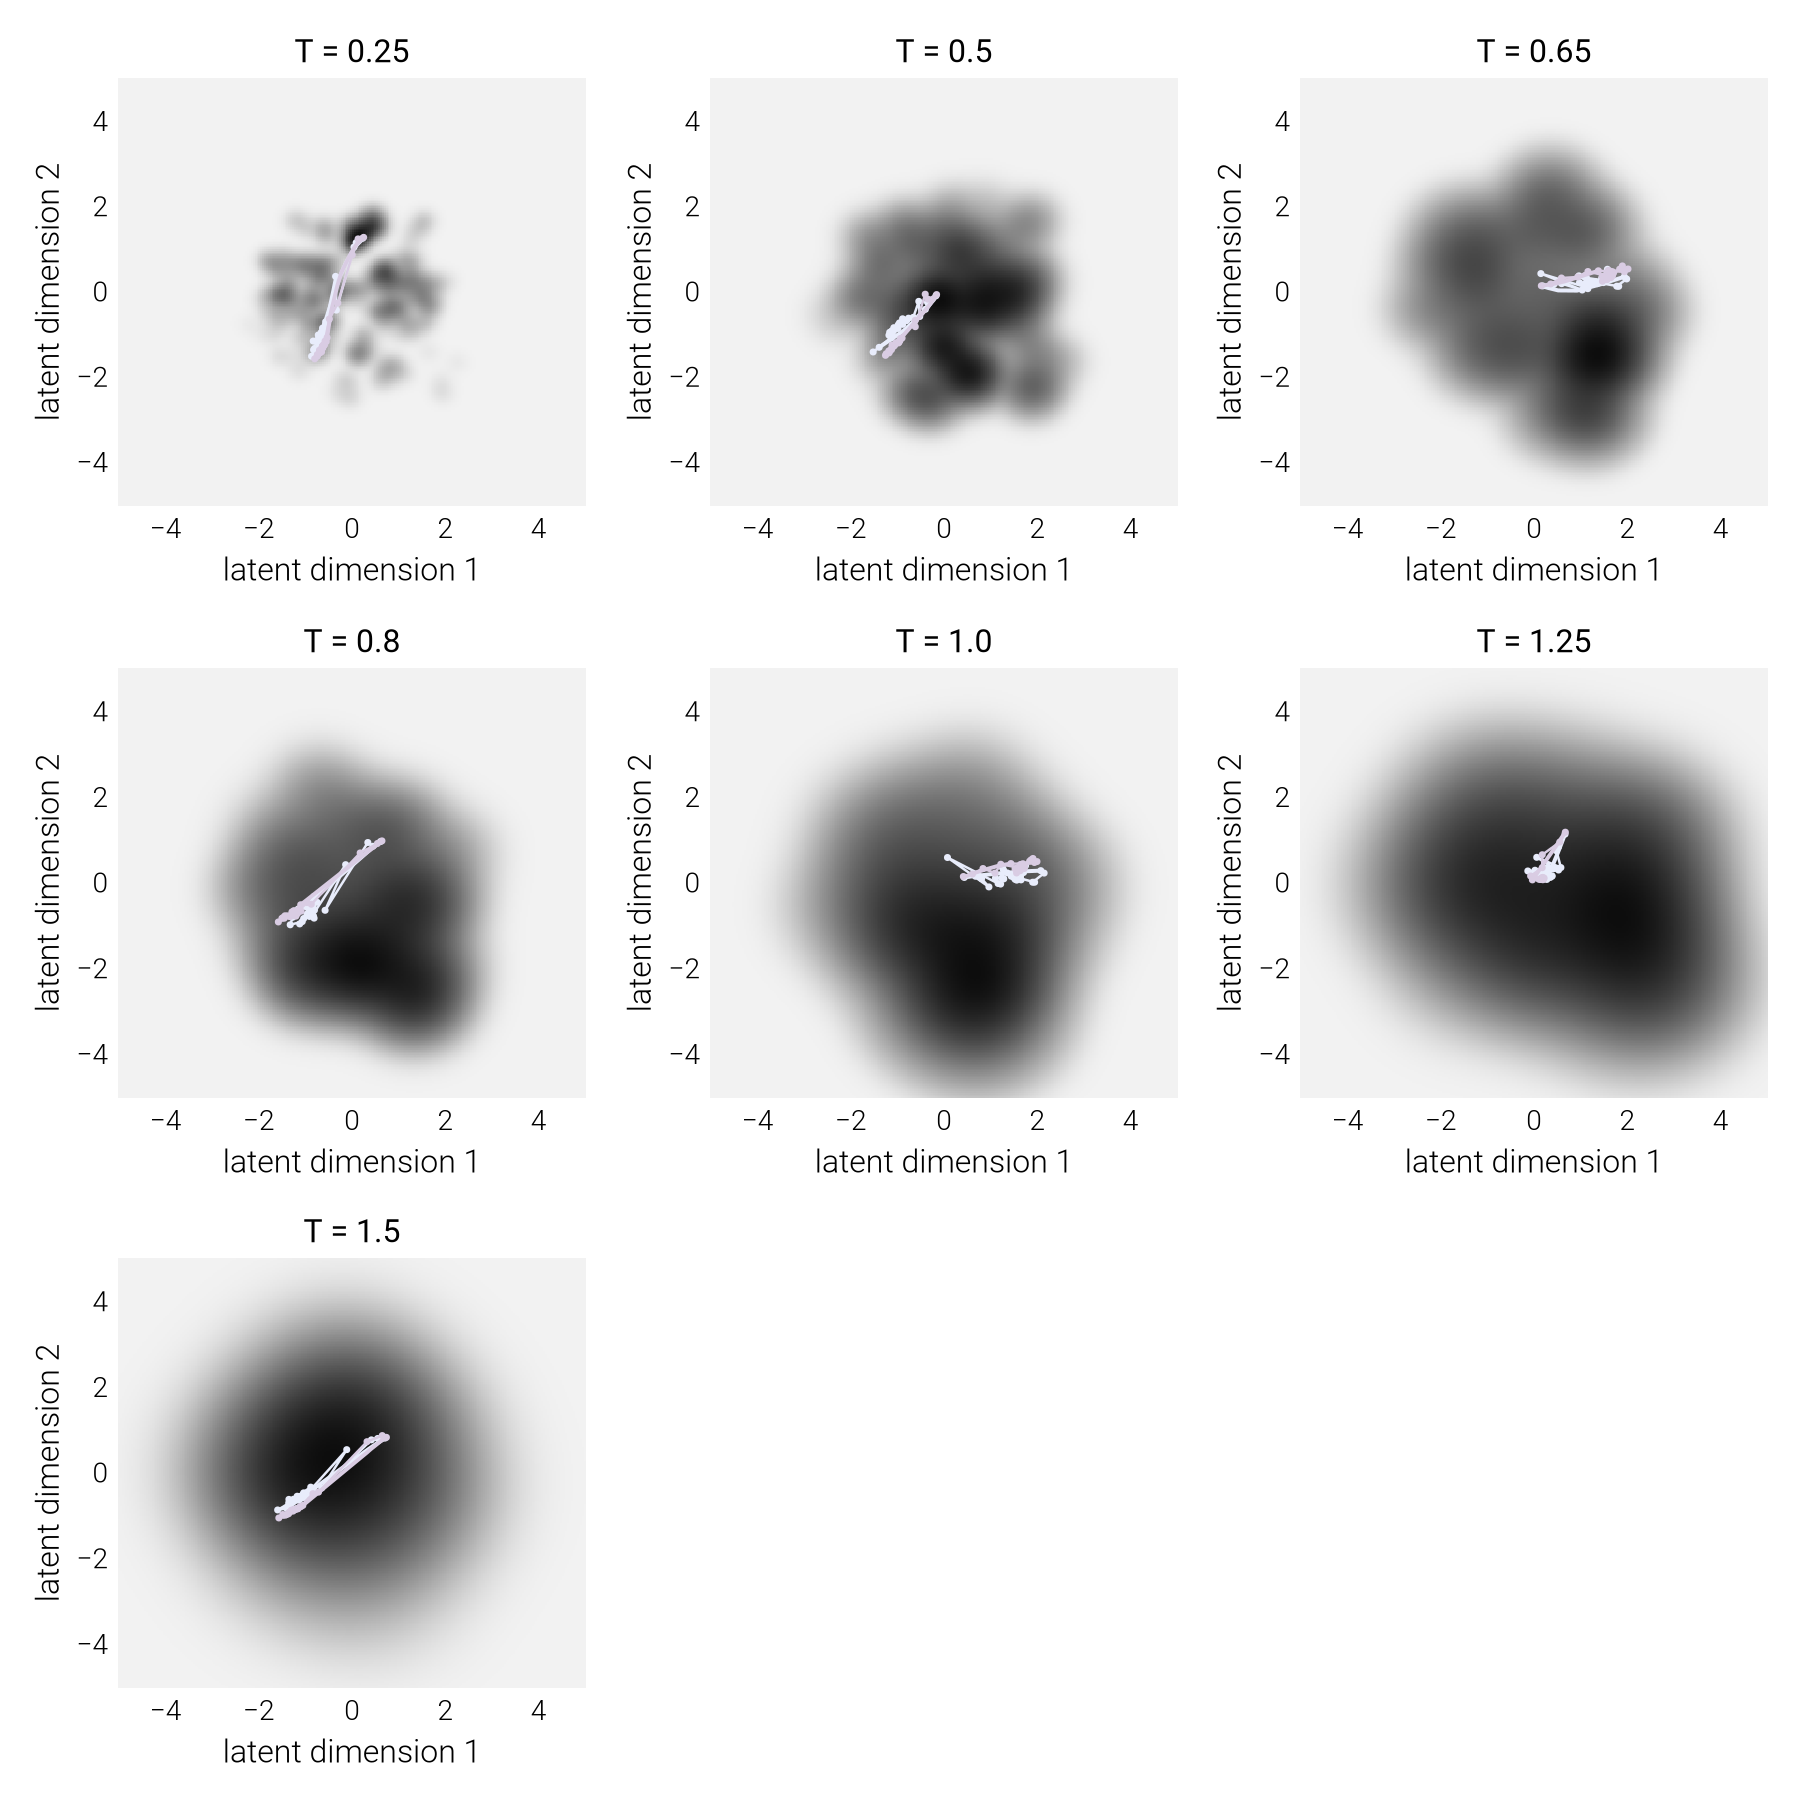

In [82]:
# Initialize plot
fig = Figure(size=(900, 900))

# Define the number of rows and columns
rows = 3
cols = 3

# Loop through temperatures
for (i, temp) in enumerate(temps)
    # Get latent space
    latent = rhvae_dict["$(temp)"]["latent"]

    # Get log determinant of metric tensor
    logdetG = rhvae_dict["$(temp)"]["logdetG"]

    # Calculate row and column indices
    row = (i - 1) ÷ cols + 1
    col = (i - 1) % cols + 1

    # Add axis to plot
    ax = Axis(
        fig[row, col],
        xlabel="latent dimension 1",
        ylabel="latent dimension 2",
    )
    # Plot heatmap of log determinant of metric tensor
    hm = heatmap!(ax, latent_range, latent_range, logdetG, colormap=:grays)
    # Extract data
    data = df_meta_mat[(df_meta_mat.temp.==temp), :]

    # Group data by strain
    df_group = DF.groupby(data[data.env.=="TET", :], :strain)

    # Loop through groups
    for (j, data) in enumerate(df_group[1:2])
        # Add scatter plot to axis
        scatterlines!(
            ax,
            data.z1,
            data.z2,
            markersize=5,
            label=data.strain[1],
            # color=ColorSchemes.tableau_20[2*j-1],
            color=ColorSchemes.tol_rainbow[j]
        )
        # Extract group metadata
        env = data.env[1]
        temp = data.temp[1]
        strain = data.strain[1]

        # Search for model files
        file = Glob.glob(
            "./output/geodesic_state/neuralgeodesic_$(temp)_$(env)env_" *
            "$(replace(strain, " " => "-"))strain*"
        )[1]
        # Load file
        nng_dict = JLD2.load(file)

        # Define NeuralGeodesic model
        nng = NG.NeuralGeodesic(
            nng_template.mlp,
            nng_dict["z_init"],
            nng_dict["z_end"],
        )
        # Load parameters
        Flux.loadmodel!(nng, nng_dict["model_state"])
        # Generate curve
        curve = nng(t_array)

        # Add geodesic to axis
        lines!(
            ax,
            curve[1, :],
            curve[2, :],
            linewidth=2,
            color=ColorSchemes.tol_rainbow[j]
            # color=ColorSchemes.tableau_20[2*j],
        )
    end # for

    # Set subplot title
    ax.title = "T = $(replace(temp, "temp" => ""))"
end # for

fig

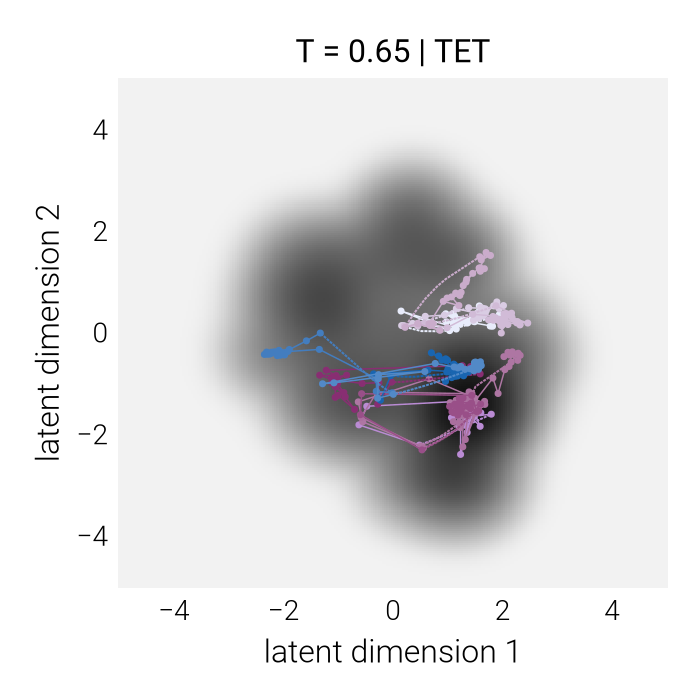

In [79]:
# Define temp
temp = "0.65temp"
# Define env
env = "TET"

# Initialize plot
fig = Figure(size=(350, 350))

# Get latent space
latent = rhvae_dict["$(temp)"]["latent"]

# Get log determinant of metric tensor
logdetG = rhvae_dict["$(temp)"]["logdetG"]

# Add axis to plot
ax = Axis(
    fig[1, 1],
    xlabel="latent dimension 1",
    ylabel="latent dimension 2",
)
# Plot heatmap of log determinant of metric tensor
hm = heatmap!(ax, latent_range, latent_range, logdetG, colormap=:grays)
# Extract data
data = df_meta_mat[(df_meta_mat.temp.==temp), :]

# Group data by strain
df_group = DF.groupby(data[data.env.==env, :], :strain)

# Loop through groups
for (j, data) in enumerate(df_group)
    # Add scatter plot to axis
    scatterlines!(
        ax,
        data.z1,
        data.z2,
        markersize=5,
        linewidth=0.75,
        label=data.strain[1],
        color=ColorSchemes.tol_rainbow[j]
    )
    # Extract group metadata
    env = data.env[1]
    temp = data.temp[1]
    strain = data.strain[1]

    # Search for model files
    file = Glob.glob(
        "./output/geodesic_state/neuralgeodesic_$(temp)_$(env)env_" *
        "$(replace(strain, " " => "-"))strain*"
    )[1]
    # Load file
    nng_dict = JLD2.load(file)

    # Define NeuralGeodesic model
    nng = NG.NeuralGeodesic(
        nng_template.mlp,
        nng_dict["z_init"],
        nng_dict["z_end"],
    )
    # Load parameters
    Flux.loadmodel!(nng, nng_dict["model_state"])
    # Generate curve
    curve = nng(t_array)

    # Add geodesic to axis
    lines!(
        ax,
        curve[1, :],
        curve[2, :],
        linewidth=1,
        # linestyle=:dot,
        linestyle=Linestyle([0.5, 1.0, 1.5, 2.5]),
        color=ColorSchemes.tol_rainbow[j]
        # color=ColorSchemes.tableau_20[2*j],
    )
end # for

# Set subplot title
ax.title = "T = $(replace(temp, "temp" => "")) | $(env)"

fig